In [20]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import os, sys

**Check if run on GPU**

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494199614865941496, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3188244480
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11114540913009946712
 physical_device_desc: "device: 0, name: Quadro M2200, pci bus id: 0000:01:00.0, compute capability: 5.2"]

**Define some plotting function for Images Plotting**

In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

## Autoencoder (2 layers + linear activation function + MSE loss) --> PCA
- For detailed proof, check [Geoffrey Hinton’s discussion](https://www.youtube.com/watch?v=hbU7nbVDzGE).

In [4]:
# Generate 3D data first. Later to be encoded to 2D.
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [5]:
# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [6]:
# Start building our Graph

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name='X')
hidden = tf.layers.dense(X, n_hidden, activation=None)
outputs = tf.layers.dense(hidden, n_outputs, activation=None)

mse_loss = tf.reduce_mean(tf.square(X - outputs), axis=0)
learning_rate = 1e-2
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse_loss)

init = tf.global_variables_initializer()

In [11]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for i in range(n_iterations):
        sess.run(training_op, feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

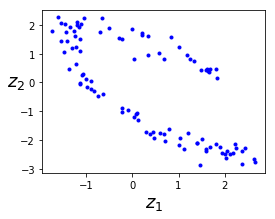

In [12]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)

plt.show()

## Stacked Autoencoders
- AutoEncoder, which has more layers, is able to encode more complex features.
- To train a stacked-AE: 
 - option_1. Simply build the whole AE in one graph. 
 - option_2. (Multiple Graphs) Train one layer in one graph and finally stack them all together.
 - option_3. (Single Graph with multiple Training_Op) Build one graph, but each layer would have one training_op!

In [13]:
# Try MNIST first
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Option_1: Train all layers at once
<br>
A stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

In [18]:
tf.reset_default_graph()

# To avoid assigning repeated params, use python's functools.partial()
from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

# Define the dense layers using Partial()
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.selu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
# Remember to add the Reg_loss to the Total_los
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
n_epoch =15
batch_size = 150

with tf.Session() as sess:
    init.run()
    n_batches = mnist.train.num_examples // batch_size
    for epoch in range(n_epoch):
        for iteration in range(n_batches):
            print('\r{}%'.format(100 * iteration // n_batches), end='')
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Autoencoder. We don't need the label y.
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch}) # Reg_losses not included
        print('\r{}'.format(epoch), 'Train MSE:', loss_train)
    saver.save(sess, './autoencoder_model/stacked_ae.ckpt')

09% Train MSE: 0.04097553
1 Train MSE: 0.02877916
2 Train MSE: 0.019250937
39% Train MSE: 0.0126532605
4 Train MSE: 0.009972293
5 Train MSE: 0.008374584
6 Train MSE: 0.0084145265
7 Train MSE: 0.007798705
8 Train MSE: 0.008502042
9 Train MSE: 0.0087495325
10 Train MSE: 0.00893975
11% Train MSE: 0.009393176
12 Train MSE: 0.008807243
13% Train MSE: 0.009257602
14% Train MSE: 0.0094212815



This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

In [27]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./autoencoder_model/stacked_ae.ckpt


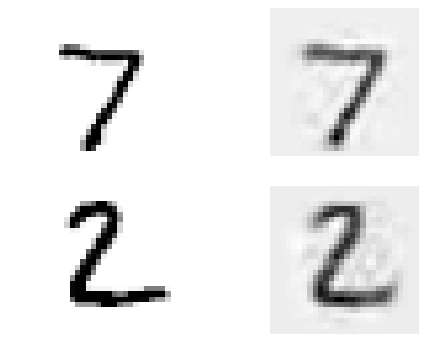

In [28]:
show_reconstructed_digits(X, outputs, './autoencoder_model/stacked_ae.ckpt')

## Tying weights
<br> 
It is common to tie the weights of the encoder and the decoder (weights_decoder = tf.transpose(weights_encoder)). 
<br> 
Unfortunately this makes it impossible (or very tricky) to use the tf.layers.dense() function. It's better to build the Autoencoder manually:
<br><br> 
Notice:
-  Only W1, W2 are Variables. W3, W4 are just their Transposed.
-  Therefore, only regularize W1, W2. (also, we will never need to regularize Biases.)

In [33]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [34]:
he_init = tf.contrib.layers.variance_scaling_initializer()

weights1_init = he_init([n_inputs, n_hidden1])
weights2_init = he_init([n_hidden1, n_hidden2])

weights1 = tf.Variable(dtype=tf.float32, initial_value=weights1_init, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

activation = tf.nn.elu
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
# Previously, we just obtain all reg_lossess. `reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)`
# with tying weights, we only regularize W1 and W2
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [35]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
    saver.save(sess, './autoencoder_model/stacked_ae.ckpt')

09% Train MSE: 0.015681125
1 Train MSE: 0.016084416
2 Train MSE: 0.016348831
3 Train MSE: 0.015746456
4 Train MSE: 0.017505854
59% Train MSE: 0.017620929
69% Train MSE: 0.017270502
79% Train MSE: 0.01702952
8 Train MSE: 0.017408336
9 Train MSE: 0.017283553


INFO:tensorflow:Restoring parameters from ./autoencoder_model/stacked_ae.ckpt


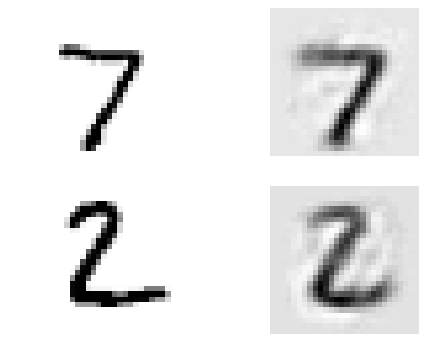

In [36]:
show_reconstructed_digits(X, outputs, './autoencoder_model/stacked_ae.ckpt')

## Option_2 : (Multiple Graphs) Train Stacked Autoencoder

In [41]:
tf.reset_default_graph()

from functools import partial

# A graph would only have 1 middle layer. So just need to define n_neurons in that middle layer.
def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate=0.01, l2_reg=0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    # 1. Start building Graph
    graph = tf.Graph()
    # set it as default graph now
    with graph.as_default():
        tf.set_random_seed(seed)
        n_inputs = X_train.shape[1]
        X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs))
        my_dense_layer = partial(tf.layers.dense, 
                                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
        
        # the weights are stored in "hidden/kernel:0" and "hidden/bias:0"
        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name='hidden')
        # the weights are stored in "outputs/kernel:0" and "outputs/bias:0"
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name='outputs')
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()
        
    # 2. Start Execution and Training
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            
        # Get the Weights values we need.
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]
    

Now let's train two Autoencoders. 
- The first one is trained on the training data.
- The second is trained on the previous Autoencoder's hidden layer output:

In [42]:
# Every single model will only have one Middel Layer. So we can easily code it.

hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

09% Train MSE: 0.018396249
19% Train MSE: 0.020109544
29% Train MSE: 0.01899802
3 Train MSE: 0.018596748
0 Train MSE: 0.004617357
1 Train MSE: 0.004662673
29% Train MSE: 0.0049046576
3 Train MSE: 0.004734418



Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [39]:
tf.reset_default_graph()
n_inputs = 28*28

# Just multiply with the W1~W4 we already computed!
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

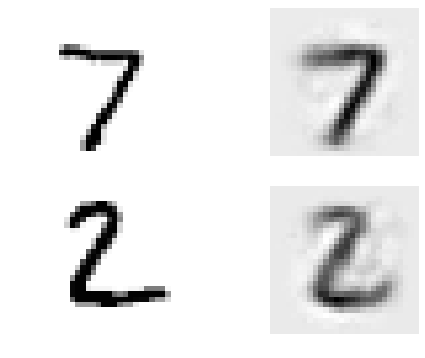

In [40]:
show_reconstructed_digits(X, outputs)

## Option3: (Single Graph with multiple training op) Train Stacked Autoencoder
<br> 
Another approach is to use a single graph. To do this, we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently:<br>  **phase 1** trains the bottom and top layer (ie. the first Autoencoder) and **phase 2** trains the two middle layers (with the outputs of the first layer frozen).

#### First, same code as before, build the whole AutoEncoder at once.

In [70]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

#### Second, define 1 training_op for each pair of Encoder and Decoder.
<br>  - For phase1, remember to bypass the other layers.
```python
phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
```
Don't use `phase1_outputs = outputs` since `outputs = tf.matmul(hidden3, weights4) + biases4` contains hidden3. BackProp will follow hidden3 all the way down to the input... <br> <br>
If using `phase1_outputs = outputs`, then just tell tf `var_list=train_vars`
<br> <br> 
<br>  - For phase2, remember to tell TensorFlow the trainable var_list (only the middle two layers' vars)
```python 
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1
```

In [71]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope('phase1'):
    # bypass hidden2 and hidden3, don't `phase1_outputs = outputs`
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

# For phase2, remember to tell TensorFlow the trainable var_list (only the middle two layers' vars)
with tf.name_scope('phase2'):
    phase2_output = hidden3
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(phase2_output - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1    

In [72]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#### During Training: train Single AE one by one.
```python
with tf.Session() as sess:
    init.run()
    # Single AE one by one
    for phase in range(2):
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
```

In [73]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    # Single AE one by one
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
    saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.007803605
1 Train MSE: 0.007744944
2 Train MSE: 0.007998116
3 Train MSE: 0.008073581
Training phase #2
09% Train MSE: 0.109471984
1 Train MSE: 0.0038547874
2 Train MSE: 0.0025729355
3 Train MSE: 0.002164438
Test MSE: 0.009783553


### Cache the frozen layer outputs
Since lower layer remain frozen during deeper layers' training. <br>
We can reduce computation by caching.
```python
with tf.Session() as sess:
    init.run()
    for phase in range(2):
       # ADD This. Then much faster in phase==2.
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
```

In [74]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [10, 10]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        # ADD This. Then much faster in phase==2.
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
    saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.007508529
1 Train MSE: 0.007356257
2 Train MSE: 0.0073972503
3 Train MSE: 0.007628321
4 Train MSE: 0.008206721
5 Train MSE: 0.008643992
6 Train MSE: 0.0082890345
79% Train MSE: 0.008689321
8 Train MSE: 0.008485675
9 Train MSE: 0.008699332
Training phase #2
09% Train MSE: 0.0029194492
1 Train MSE: 0.0020850312
29% Train MSE: 0.0020559004
3 Train MSE: 0.0020953678
4 Train MSE: 0.0020503115
59% Train MSE: 0.0020502748
6 Train MSE: 0.0021221125
7 Train MSE: 0.0021476143
8 Train MSE: 0.0021296872
99% Train MSE: 0.0023367421
Test MSE: 0.011186773


## Finally, Visualizing the Reconstructions

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


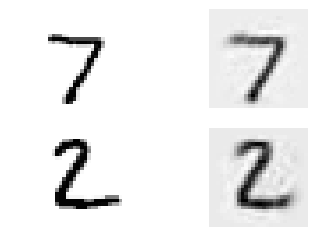

In [75]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## Visualizing the extracted features

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


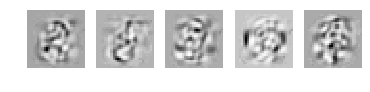

In [76]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

plt.show()